In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.3.0


### Get the data
First download and import the dataset using pandas:

In [4]:
url = '../input/yeh-concret-data/Concrete_Data_Yeh.csv'
column_names = ["cement","slag","flyash","water","superplasticizer","coarseaggregate","fineaggregate","age","csMPa"
]

raw_dataset = pd.read_csv(url)

In [5]:
dataset = raw_dataset.copy()
dataset.tail()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77
1029,260.9,100.5,78.3,200.6,8.6,864.5,761.5,28,32.40


### Clean the data

The dataset contains a few unknown values.

In [6]:
dataset.isna().sum()

cement              0
slag                0
flyash              0
water               0
superplasticizer    0
coarseaggregate     0
fineaggregate       0
age                 0
csMPa               0
dtype: int64

Drop those rows to keep this initial tutorial simple.

In [7]:
dataset = dataset.dropna()

The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot:

Note: You can set up the `keras.Model` to do this kind of transformation for you. That's beyond the scope of this tutorial. See the [preprocessing layers](../structured_data/preprocessing_layers.ipynb) or [Loading CSV data](../load_data/csv.ipynb) tutorials for examples.

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

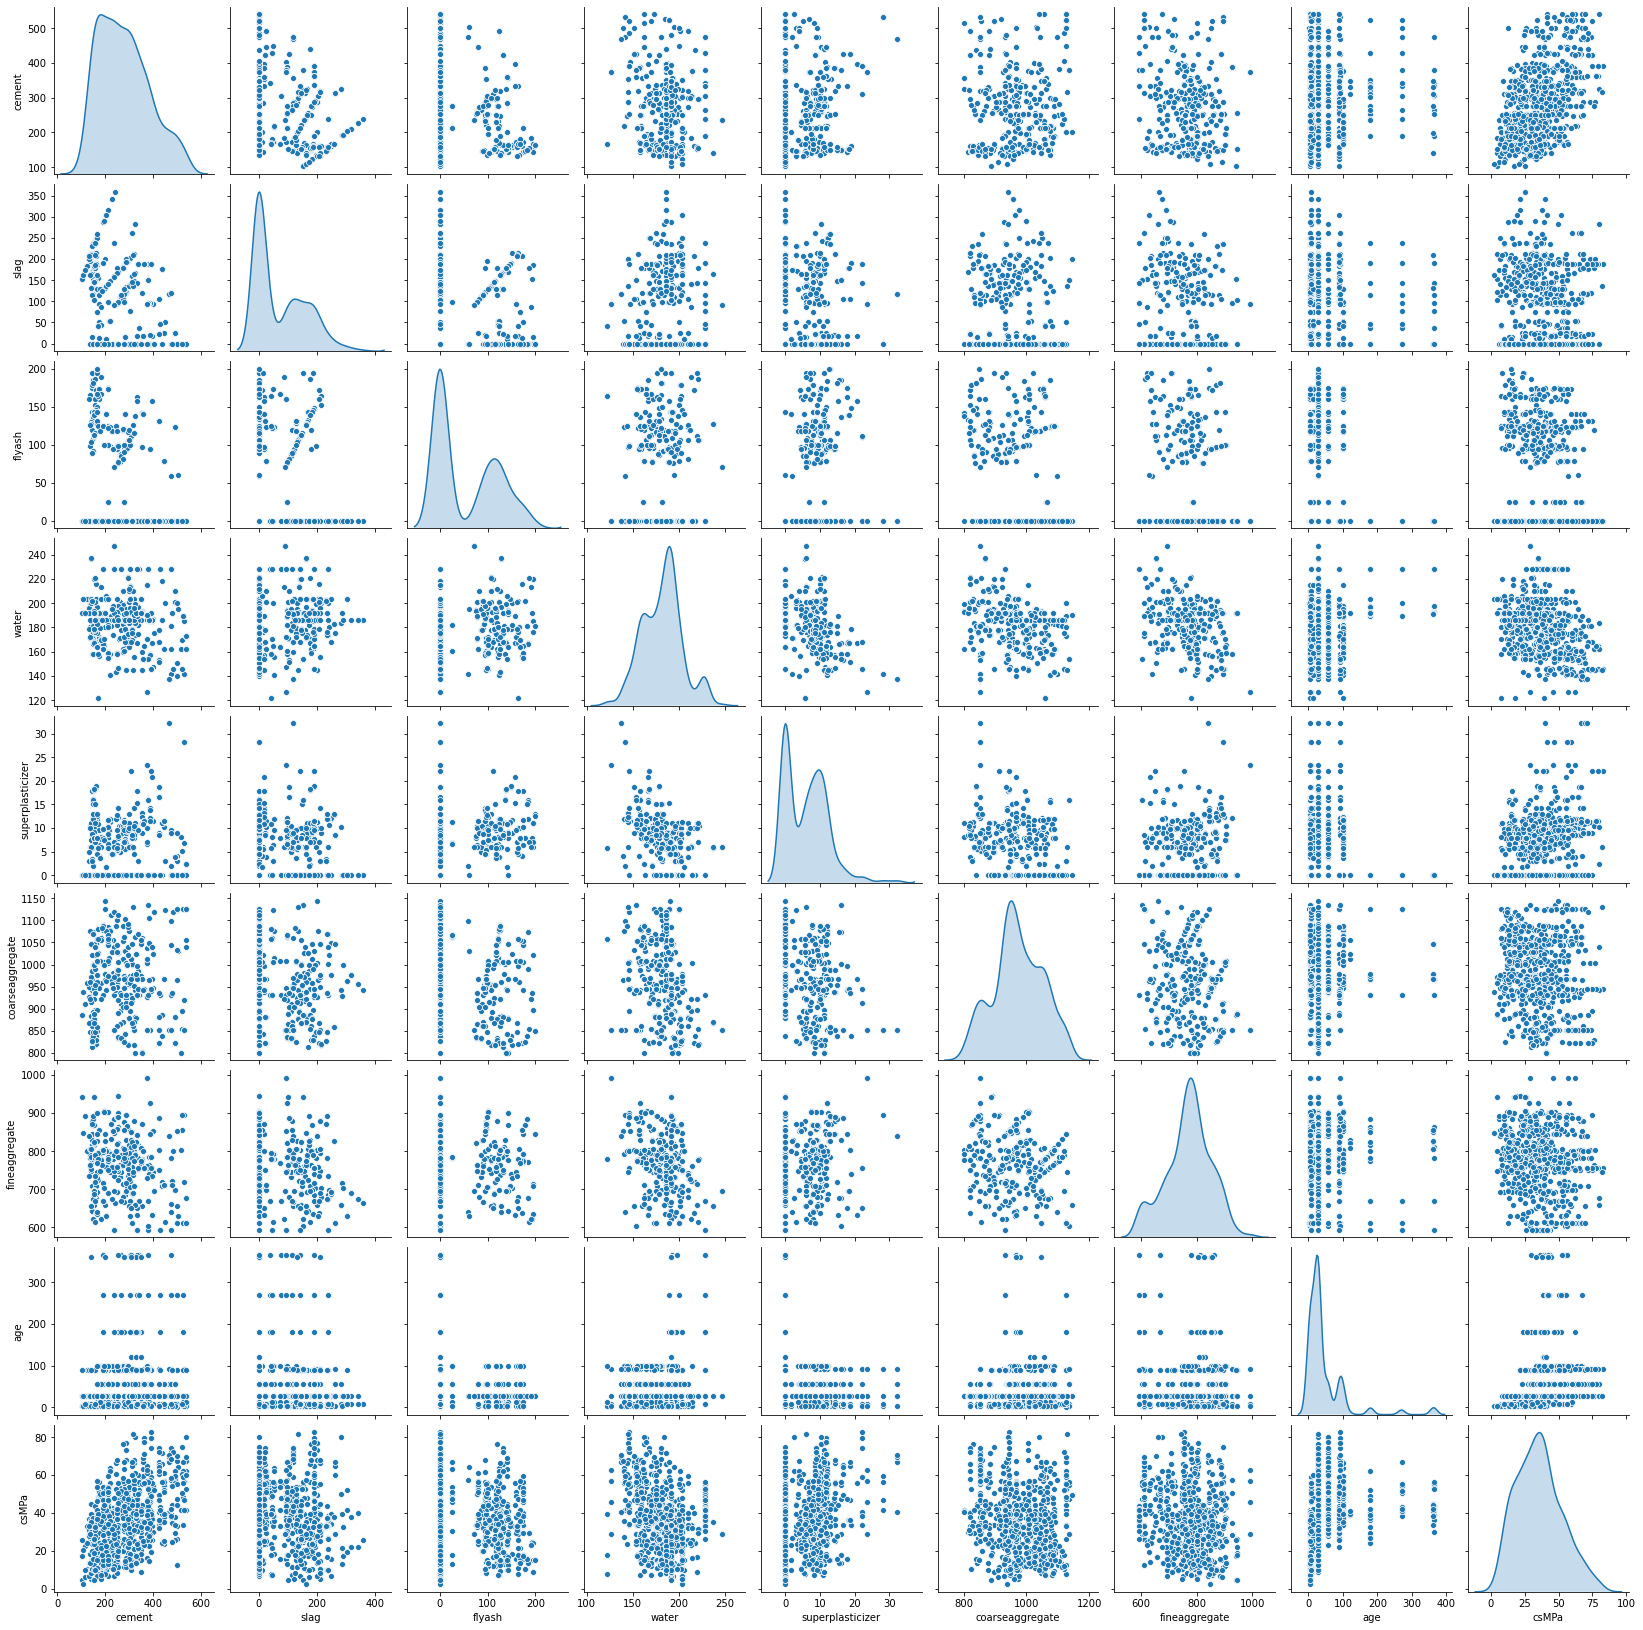

In [9]:
sns.pairplot(train_dataset[["cement","slag","flyash","water","superplasticizer","coarseaggregate","fineaggregate","age","csMPa"]], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cement,824.0,280.272694,104.483467,102.00,193.125,266.000,350.0000,540.0
slag,824.0,73.171238,85.865727,0.00,0.000,22.000,142.5000,359.4
flyash,824.0,55.318325,64.098118,0.00,0.000,0.000,118.3000,200.1
water,824.0,182.029490,21.287699,121.80,164.900,185.700,192.0000,247.0
superplasticizer,824.0,6.147816,6.000795,0.00,0.000,6.100,10.1250,32.2
coarseaggregate,824.0,973.991019,77.755840,801.00,932.000,968.000,1030.2500,1145.0
fineaggregate,824.0,771.898301,80.031529,594.00,721.750,779.300,824.0000,992.6
age,824.0,45.708738,63.603343,1.00,7.000,28.000,56.0000,365.0
csMPa,824.0,35.739478,16.582095,2.33,23.520,34.425,46.2075,82.6


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('csMPa')
test_labels = test_features.pop('csMPa')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [12]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
cement,280.272694,104.483467
slag,73.171238,85.865727
flyash,55.318325,64.098118
water,182.029490,21.287699
superplasticizer,6.147816,6.000795
coarseaggregate,973.991019,77.755840
fineaggregate,771.898301,80.031529
age,45.708738,63.603343
csMPa,35.739478,16.582095


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [13]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [14]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [15]:
print(normalizer.mean.numpy())

[280.273  73.171  55.318 182.029   6.148 973.991 771.898  45.709]


When the layer is called it returns the input data, with each feature independently normalized:

In [16]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 500.    0.    0.  200.    0. 1125.  613.    3.]]

Normalized: [[ 2.1  -0.85 -0.86  0.84 -1.03  1.94 -1.99 -0.67]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `MPG` from `Horsepower`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `horsepower`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [17]:
superplasticizer = np.array(train_features['superplasticizer'])

superplasticizer_normalizer = preprocessing.Normalization(input_shape=[1,])
superplasticizer_normalizer.adapt(superplasticizer)

Build the sequential model:

In [18]:
superplasticizer_model = tf.keras.Sequential([
    superplasticizer_normalizer,
    layers.Dense(units=1)
])

superplasticizer_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `MPG` from `Horsepower`.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [19]:
superplasticizer_model.predict(superplasticizer[:10])

array([[ 1.601],
       [ 1.601],
       [-1.42 ],
       [ 1.601],
       [ 1.601],
       [-2.539],
       [-0.743],
       [-0.977],
       [ 0.95 ],
       [ 1.601]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [20]:
superplasticizer_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [21]:
%%time
history = superplasticizer_model.fit(
    train_features['superplasticizer'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 5.02 s, sys: 543 ms, total: 5.57 s
Wall time: 4.53 s


Visualize the model's training progress using the stats stored in the `history` object.

In [22]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,12.480742,13.053048,95
96,12.481355,13.053528,96
97,12.481915,13.055275,97
98,12.484126,13.046395,98
99,12.480236,13.071665,99


In [23]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 100])
  plt.xlabel('Epoch')
  plt.ylabel('Error [csMPa]')
  plt.legend()
  plt.grid(True)

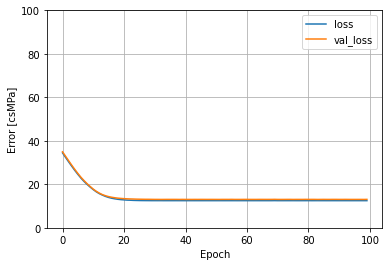

In [24]:
plot_loss(history)

Collect the results on the test set, for later:

In [25]:
test_results = {}

test_results['superplasticizer'] = superplasticizer_model.evaluate(
    test_features['superplasticizer'],
    test_labels, verbose=0)

SInce this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [26]:
x = tf.linspace(10, 70, 101)
y = superplasticizer_model.predict(x)

In [27]:
def plot_superplasticizer(x, y):
  plt.scatter(train_features['superplasticizer'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('superplasticizer')
  plt.ylabel('csMPa')
  plt.legend()

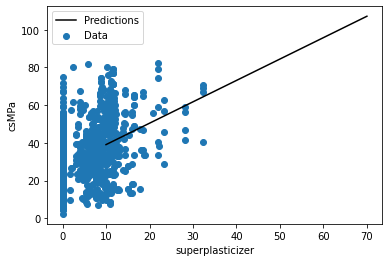

In [28]:
plot_superplasticizer(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [29]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [30]:
linear_model.predict(train_features[:10])

array([[-2.747],
       [ 1.038],
       [-0.711],
       [ 0.729],
       [ 1.113],
       [-4.771],
       [-2.948],
       [-1.241],
       [-2.482],
       [ 0.686]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [31]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(8, 1) dtype=float32, numpy=
array([[ 0.058],
       [ 0.376],
       [ 0.769],
       [ 0.425],
       [-0.586],
       [-0.75 ],
       [ 0.64 ],
       [ 0.171]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `horsepower` model:

In [32]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [33]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 5.02 s, sys: 532 ms, total: 5.55 s
Wall time: 4.31 s


Using all the inputs achieves a much lower training and validation error than the `horsepower` model: 

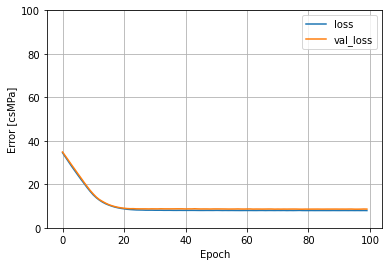

In [34]:
plot_loss(history)

Collect the results on the test set, for later:

In [35]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [36]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "Horsepower"

In [37]:
dnn_superplasticizer_model = build_and_compile_model(superplasticizer_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [38]:
dnn_superplasticizer_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [39]:
%%time
history = dnn_superplasticizer_model.fit(
    train_features['superplasticizer'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 6.19 s, sys: 764 ms, total: 6.95 s
Wall time: 5.07 s


This model does slightly better than the linear-horsepower model.

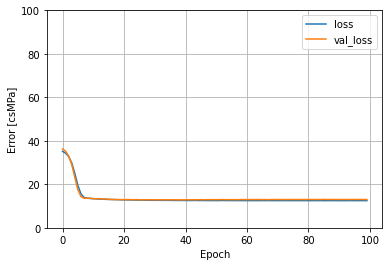

In [40]:
plot_loss(history)

If you plot the predictions as a function of `Horsepower`, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [41]:
x = tf.linspace(2, 50, 10)
y = dnn_superplasticizer_model.predict(x)

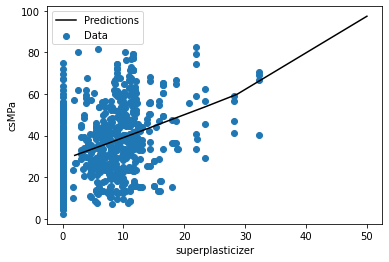

In [42]:
plot_superplasticizer(x, y)

Collect the results on the test set, for later:

In [43]:
test_results['dnn_superplasticizer_model'] = dnn_superplasticizer_model.evaluate(
    test_features['superplasticizer'], test_labels,
    verbose=0)

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [44]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 8)                 17        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 4,818
Trainable params: 4,801
Non-trainable params: 17
_________________________________________________________________


In [45]:
%%time


history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 7.2 s, sys: 965 ms, total: 8.17 s
Wall time: 5.95 s


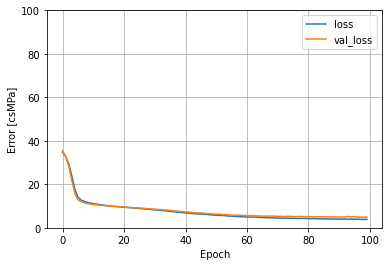

In [46]:
plot_loss(history)

Collect the results on the test set:

In [47]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [48]:
pd.DataFrame(test_results, index=['Mean absolute error [csMPa]']).T

,Mean absolute error [csMPa]
superplasticizer,12.549346
linear_model,8.182833
dnn_superplasticizer_model,12.586773
dnn_model,5.012720


These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

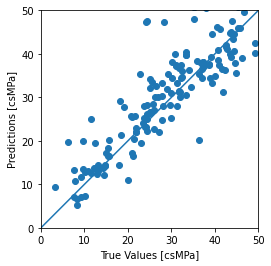

In [49]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [csMPa]')
plt.ylabel('Predictions [csMPa]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

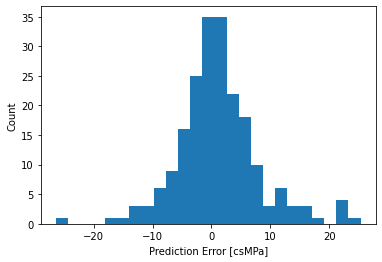

In [50]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [csMPa]')
_ = plt.ylabel('Count')

If you're happy with the model save it for later use:

In [51]:
dnn_model.save('model')

If you reload the model, it gives identical output:

In [52]:
print(test_features)

      cement   slag  flyash  water  superplasticizer  coarseaggregate  \
11     198.6  132.4     0.0  192.0               0.0            978.4   
19     475.0    0.0     0.0  228.0               0.0            932.0   
23     139.6  209.4     0.0  192.0               0.0           1047.0   
25     380.0    0.0     0.0  228.0               0.0            932.0   
28     427.5   47.5     0.0  228.0               0.0            932.0   
...      ...    ...     ...    ...               ...              ...   
999    150.9    0.0   183.9  166.6              11.6            991.2   
1003   366.0  187.0     0.0  191.3               6.6            824.3   
1014   132.0  206.5   160.9  178.9               5.5            866.9   
1018   321.4    0.0   127.9  182.5              11.5            870.1   
1021   298.2    0.0   107.0  209.7              11.1            879.6   

      fineaggregate  age  
11            825.5   28  
19            594.0  180  
23            806.9  180  
25            6

In [53]:
reloaded = tf.keras.models.load_model('model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

[[27.535]]
     cement  slag  flyash  water  superplasticizer  coarseaggregate  \
747   498.0   0.0     0.0  200.0               0.0           1125.0   

     fineaggregate  age  
747          613.0    4  


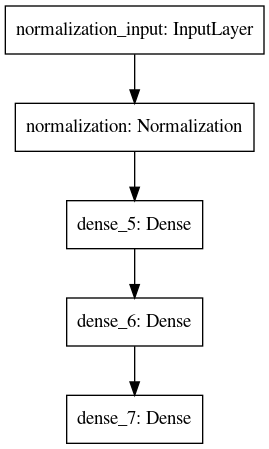

In [54]:
new_data=train_features[:1].copy()
new_data=new_data.replace([500.0, 0.0, 0.0, 200.0,0.0,1125.0,613.0,3],[498.0, 0.0, 0.0, 200.0,0.0,1125.0,613.0,4])
predict=reloaded.predict(new_data)
print(predict)
print(new_data)
tf.keras.utils.plot_model(
    reloaded, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96)

In [55]:
pd.DataFrame(test_results, index=['Mean absolute error [c]']).T

,Mean absolute error [c]
superplasticizer,12.549346
linear_model,8.182833
dnn_superplasticizer_model,12.586773
dnn_model,5.012720
reloaded,5.012720
